In [2]:
%matplotlib inline

In [3]:
import pylab as plt

In [4]:
import time
import sys
sys.path.insert(0, '/opt/usr/python/')

import astra
import numpy as np
import pandas as pd

In [5]:
def create_test_cube(size):
    # Create a simple hollow cube phantom
    cube = np.zeros((size,size,size), dtype='float32')
    x0 = int(128.*size/1024)
    x1 = int(895.*size/1024)
    y0 = int(256.*size/1024)
    y1 = int(767.*size/1024)
    cube[x0:x1,x0:x1,x0:x1] = 1
    cube[y0:y1,y0:y1,y0:y1,] = 0
    return cube

   
    
def test_projections_parallel(size, angles_count, gpus_list):
    # Set up multi-GPU usage.
    # This only works for 3D GPU forward projection and back projection.
    astra.astra.set_gpu_index(gpus_list)

    # Optionally, you can also restrict the amount of GPU memory ASTRA will use.
    # The line commented below sets this to 1GB.
    #astra.astra.set_gpu_index([0,1], memory=1024*1024*1024)
    

    angles = np.linspace(0, np.pi, angles_count, False)
    proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, size, size, angles)

    # Create a simple hollow cube phantom
    cube = create_test_cube(size)
    vol_geom = astra.create_vol_geom(cube.shape)
    cube_id = astra.data3d.create('-vol', vol_geom, cube)
    del cube
    
    print('Start create_sino3d_gpu')
    # Create projection data from this
    t=time.time()
    proj_id = astra.create_sino3d_gpu(cube_id, proj_geom, vol_geom, returnData=False)
    astra.data3d.delete(cube_id)
    
    t_proj = time.time()-t
    print('Takes: {}'.format(t_proj))

    print('Start astra.create_backprojection3d_gpu')
    # Backproject projection data
    t=time.time()
    bproj_id = astra.create_backprojection3d_gpu(proj_id, proj_geom, vol_geom, returnData=False)
    t_bproj = time.time()-t
    print('Takes: {}'.format(t_bproj))

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.data3d.info()
    astra.data3d.delete(proj_id)
    astra.data3d.delete(bproj_id)
    
    return size, angles_count, len(gpus_list), t_proj, t_bproj

def test_projections_cone(size, angles_count, gpus_list):
    # Set up multi-GPU usage.
    # This only works for 3D GPU forward projection and back projection.
    astra.astra.set_gpu_index(gpus_list)

    # Optionally, you can also restrict the amount of GPU memory ASTRA will use.
    # The line commented below sets this to 1GB.
    #astra.astra.set_gpu_index([0,1], memory=1024*1024*1024)
    

    angles = np.linspace(0, np.pi, angles_count, False)
    
    # Circular

    # Parameters: width of detector column, height of detector row, #rows, #columns,
    #             angles, distance source-origin, distance origin-detector
    
    # see example #5 from python samples
    # All distances in [pixels]
    pixel_size = 2.82473e-3
    os_distance = 56.135 / pixel_size # object-sample distance
    ds_distance = 225.082 / pixel_size # detector-sample distance
    detector_size = size
    
#     proj_geom = astra.create_proj_geom('cone', 1.0, 1.0, 32, 64, angles, 1000, 0)
    proj_geom = astra.create_proj_geom('cone', ds_distance / os_distance,ds_distance / os_distance,
                                       detector_size, detector_size, angles,
                                       os_distance, (ds_distance - os_distance))
#     proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, size, size, angles)

    # Create a simple hollow cube phantom
    cube = create_test_cube(size)
    vol_geom = astra.create_vol_geom(cube.shape)
    cube_id = astra.data3d.create('-vol', vol_geom, cube)
    del cube
    
    print('Start create_sino3d_gpu')
    # Create projection data from this
    t=time.time()
    proj_id = astra.create_sino3d_gpu(cube_id, proj_geom, vol_geom, returnData=False)
    astra.data3d.delete(cube_id)
    
    t_proj = time.time()-t
    print('Takes: {}'.format(t_proj))

    print('Start astra.create_backprojection3d_gpu')
    # Backproject projection data
    t=time.time()
    bproj_id = astra.create_backprojection3d_gpu(proj_id, proj_geom, vol_geom, returnData=False)
    t_bproj = time.time()-t
    print('Takes: {}'.format(t_bproj))

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.data3d.info()
    astra.data3d.delete(proj_id)
    astra.data3d.delete(bproj_id)
    
    return size, angles_count, len(gpus_list), t_proj, t_bproj

def test_reconstruction_cone_fdk(size, angles_count, gpus_list):
    # Set up multi-GPU usage.
    # This only works for 3D GPU forward projection and back projection.
    astra.astra.set_gpu_index(gpus_list)

    # Optionally, you can also restrict the amount of GPU memory ASTRA will use.
    # The line commented below sets this to 1GB.
    #astra.astra.set_gpu_index([0,1], memory=1024*1024*1024)
    

    angles = np.linspace(0, np.pi, angles_count, False)
    
    # Circular

    # Parameters: width of detector column, height of detector row, #rows, #columns,
    #             angles, distance source-origin, distance origin-detector
    
    # see example #5 from python samples
    # All distances in [pixels]
    pixel_size = 2.82473e-3
    os_distance = 56.135 / pixel_size # object-sample distance
    ds_distance = 225.082 / pixel_size # detector-sample distance
    detector_size = size
    
#     proj_geom = astra.create_proj_geom('cone', 1.0, 1.0, 32, 64, angles, 1000, 0)
    proj_geom = astra.create_proj_geom('cone', ds_distance / os_distance,ds_distance / os_distance,
                                       detector_size, detector_size, angles,
                                       os_distance, (ds_distance - os_distance))
#     proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, size, size, angles)

    # Create a simple hollow cube phantom
    cube = create_test_cube(size)
    vol_geom = astra.create_vol_geom(cube.shape)
    cube_id = astra.data3d.create('-vol', vol_geom, cube)
    del cube
    
    print('Start create_sino3d_gpu')
    # Create projection data from this
    t=time.time()
    proj_id = astra.create_sino3d_gpu(cube_id, proj_geom, vol_geom, returnData=False)
    
    t_proj = time.time()-t
    print('Takes: {}'.format(t_proj))

    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('FDK_CUDA')
    cfg['ReconstructionDataId'] = cube_id
    cfg['ProjectionDataId'] = proj_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)
    
#     print('Start astra reconstruction FDK_CUDA')
#     # Backproject projection data
    t=time.time()
    astra.algorithm.run(alg_id, 1)
    t_bproj = time.time()-t
    print('Takes: {}'.format(t_bproj))
    
#     rec = astra.data3d.get(cube_id)
#     plt.figure()
#     plt.imshow(rec[:,:,int(rec.shape[-1]/2)])
#     plt.show()
    

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.data3d.info()
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(proj_id)
    astra.data3d.delete(cube_id)
    
    return size, angles_count, len(gpus_list), t_proj, t_bproj

In [5]:
test_reconstruction_cone_fdk(1536,1536,[0,1])

Start create_sino3d_gpu
Takes: 96.5000932217
Takes: 97.2681100368
id  init  description
-----------------------------------------
1 	v     1536x1536x1536 volume data 	
2 	v     1536x1536x1536 sinogram data 	
-----------------------------------------



(1536, 1536, 2, 96.50009322166443, 97.26811003684998)

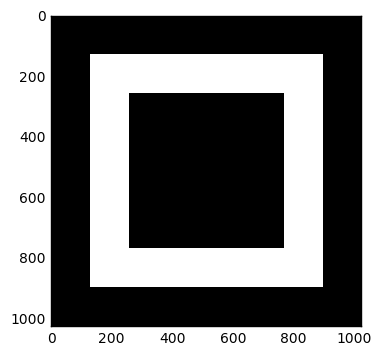

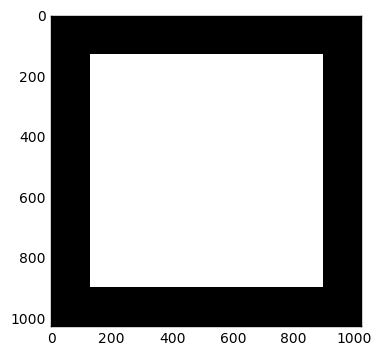

In [8]:
rec=create_test_cube(1024)
plt.figure()
plt.imshow(rec[:,:,512])
plt.show()

plt.figure()
plt.imshow(rec[:,:,200])
plt.show()

In [8]:
sizes = [1024,]
print sizes

angles = [1024,]
print angles

gpu_config = [[0,1],[0,],[1,]]
print gpu_config

[1024]
[1024]
[[0, 1], [0], [1]]


In [6]:
with open('test_proj_bproj_parallel_3d.txt', 'a') as f:
    for angles_count in angles:
        for size in sizes:
            for gpu_list in gpu_config:
                res = test_projections_parallel(size, angles_count, gpu_list)
                f.write('\t'.join(map(lambda x: str(x),res)))
                f.write('\n')

Start create_sino3d_gpu
Takes: 0.41002702713
Start astra.create_backprojection3d_gpu
Takes: 0.0132400989532
id  init  description
-----------------------------------------
2 	v     128x128x128 sinogram data 	
4 	v     128x128x128 volume data 	
-----------------------------------------

Start create_sino3d_gpu
Takes: 0.0148339271545
Start astra.create_backprojection3d_gpu
Takes: 0.0135180950165
id  init  description
-----------------------------------------
7 	v     128x128x128 sinogram data 	
9 	v     128x128x128 volume data 	
-----------------------------------------

Start create_sino3d_gpu
Takes: 0.0156922340393
Start astra.create_backprojection3d_gpu
Takes: 0.0120189189911
id  init  description
-----------------------------------------
12 	v     128x128x128 sinogram data 	
14 	v     128x128x128 volume data 	
-----------------------------------------

Start create_sino3d_gpu
Takes: 0.045037984848
Start astra.create_backprojection3d_gpu
Takes: 0.0888438224792
id  init  description
--

In [144]:
with open('test_proj_bproj_cone_3d.txt', 'a') as f:
    for angles_count in angles:
        for size in sizes:
            for gpu_list in gpu_config:
                res = test_projections_cone(size, angles_count, gpu_list)
                f.write('\t'.join(map(lambda x: str(x),res)))
                f.write('\n')

Start create_sino3d_gpu
Takes: 0.0701348781586
Start astra.create_backprojection3d_gpu
Takes: 0.0246939659119
id  init  description
-----------------------------------------
242 	v     128x512x128 sinogram data 	
244 	v     128x128x128 volume data 	
-----------------------------------------

Start create_sino3d_gpu
Takes: 0.0522820949554
Start astra.create_backprojection3d_gpu
Takes: 0.0315330028534
id  init  description
-----------------------------------------
247 	v     128x512x128 sinogram data 	
249 	v     128x128x128 volume data 	
-----------------------------------------

Start create_sino3d_gpu
Takes: 0.0435647964478
Start astra.create_backprojection3d_gpu
Takes: 0.0270969867706
id  init  description
-----------------------------------------
252 	v     128x512x128 sinogram data 	
254 	v     128x128x128 volume data 	
-----------------------------------------

Start create_sino3d_gpu
Takes: 0.147379875183
Start astra.create_backprojection3d_gpu
Takes: 0.125758886337
id  init  des

In [9]:
with open('test_rec_cone_3d.txt', 'a') as f:
    for angles_count in angles:
        for size in sizes:
            for gpu_list in gpu_config:
                res = test_reconstruction_cone_fdk(size, angles_count, gpu_list)
                f.write('\t'.join(map(lambda x: str(x),res)))
                f.write('\n')

Start create_sino3d_gpu
Takes: 16.4730708599
Takes: 21.5482540131
id  init  description
-----------------------------------------
1 	v     1024x1024x1024 volume data 	
2 	v     1024x1024x1024 sinogram data 	
-----------------------------------------

Start create_sino3d_gpu
Takes: 21.0576431751
Takes: 38.8112969398
id  init  description
-----------------------------------------
5 	v     1024x1024x1024 volume data 	
6 	v     1024x1024x1024 sinogram data 	
-----------------------------------------

Start create_sino3d_gpu
Takes: 27.9634079933
Takes: 34.658064127
id  init  description
-----------------------------------------
9 	v     1024x1024x1024 volume data 	
10 	v     1024x1024x1024 sinogram data 	
-----------------------------------------



In [7]:
stat = np.loadtxt('test_proj_bproj_parallel_3d.txt')

In [14]:
#!rm test_proj_bproj_parallel_3d.txt

rm: cannot remove ‘test_proj_bproj_parallel_3d.txt’: No such file or directory


In [100]:
size = stat[:,0]
angles_count =  stat[:,1]
gpus = stat[:,2]
t_proj = stat[:,3]
t_bproj = stat[:,4]

In [101]:
df = pd.DataFrame(stat,columns=['size', 'angles', 'ngpus', 't_proj', 't_bproj'])

In [102]:
db = df.groupby(['ngpus'])

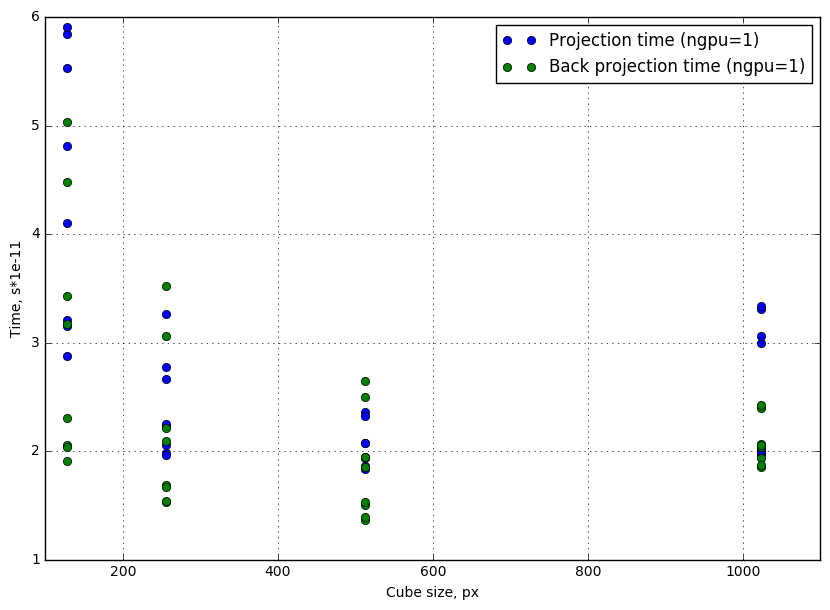

In [129]:
plt.figure(figsize=(10,7))
gpu_index = db.groups[1]

plt.plot(df['size'][gpu_index],
         df['t_proj'][gpu_index]/df['size'][gpu_index]**3/df['angles'][gpu_index]*1e11,
         'o',
         label='Projection time (ngpu=1)')

plt.plot(df['size'][gpu_index],
         df['t_bproj'][gpu_index]/df['size'][gpu_index]**3/df['angles'][gpu_index]*1e11,
         'o',
         label='Back projection time (ngpu=1)')

# multi_gpu_index = db.groups[2]
# plt.plot(df['size'][multi_gpu_index],df['t_proj'][multi_gpu_index] , '*', label='Projection time (ngpu=2)')
# plt.plot(df['size'][multi_gpu_index],df['t_bproj'][multi_gpu_index] , 'x', label='Back projection time (ngpu=2)')
plt.ylabel('Time, s*1e-11')
plt.xlabel('Cube size, px')
plt.grid(True)
plt.legend(loc=0)
plt.show()

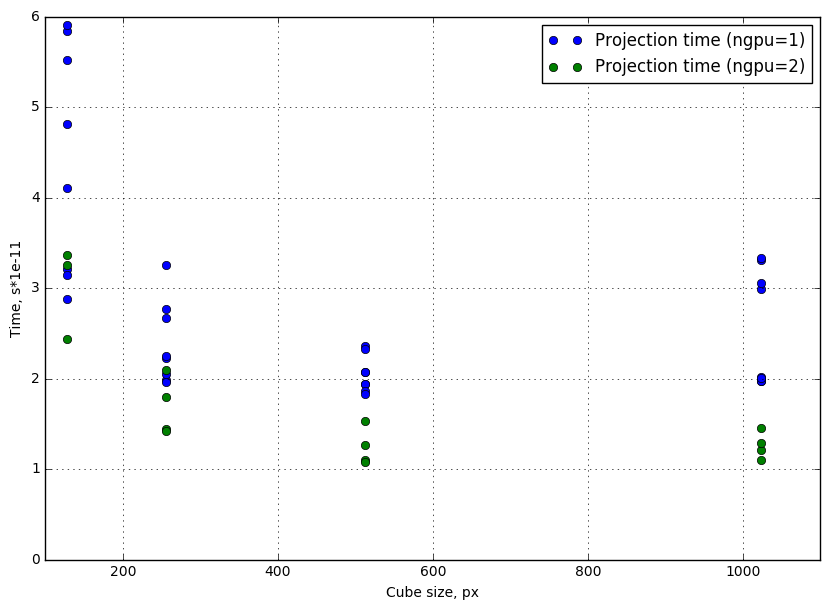

In [140]:
plt.figure(figsize=(10,7))
gpu_index = db.groups[1]

plt.plot(df['size'][gpu_index],
         df['t_proj'][gpu_index]/df['size'][gpu_index]**3/df['angles'][gpu_index]*1e11,
         'o',
         label='Projection time (ngpu=1)')

gpu_index = db.groups[2]
plt.plot(df['size'][gpu_index],
         df['t_proj'][gpu_index]/df['size'][gpu_index]**3/df['angles'][gpu_index]*1e11,
         'o',
         label='Projection time (ngpu=2)')
plt.ylim([0,6])

# multi_gpu_index = db.groups[2]
# plt.plot(df['size'][multi_gpu_index],df['t_proj'][multi_gpu_index] , '*', label='Projection time (ngpu=2)')
# plt.plot(df['size'][multi_gpu_index],df['t_bproj'][multi_gpu_index] , 'x', label='Back projection time (ngpu=2)')
plt.ylabel('Time, s*1e-11')
plt.xlabel('Cube size, px')
plt.grid(True)
plt.legend(loc=0)
plt.show()

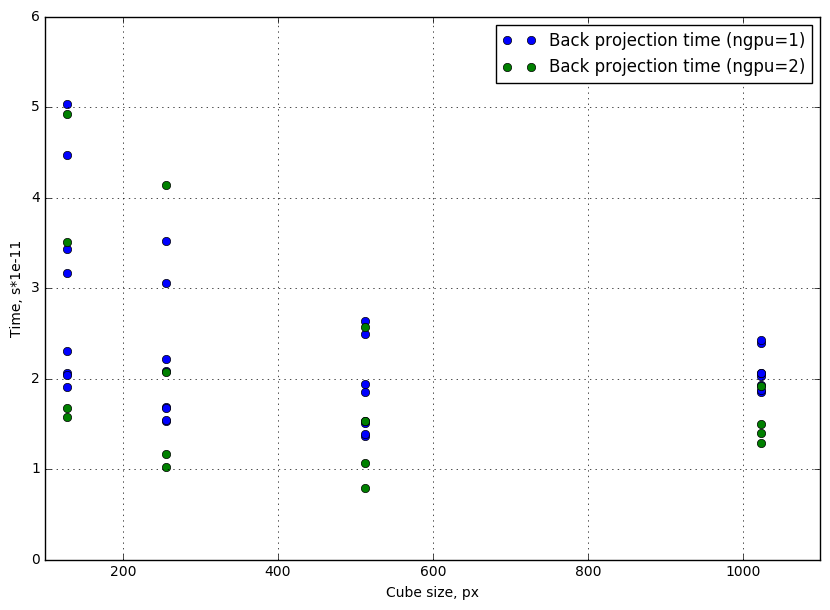

In [137]:
plt.figure(figsize=(10,7))
gpu_index = db.groups[1]

plt.plot(df['size'][gpu_index],
         df['t_bproj'][gpu_index]/df['size'][gpu_index]**3/df['angles'][gpu_index]*1e11,
         'o',
         label='Back projection time (ngpu=1)')

gpu_index = db.groups[2]
plt.plot(df['size'][gpu_index],
         df['t_bproj'][gpu_index]/df['size'][gpu_index]**3/df['angles'][gpu_index]*1e11,
         'o',
         label='Back projection time (ngpu=2)')
plt.ylim([0,6])

# multi_gpu_index = db.groups[2]
# plt.plot(df['size'][multi_gpu_index],df['t_proj'][multi_gpu_index] , '*', label='Projection time (ngpu=2)')
# plt.plot(df['size'][multi_gpu_index],df['t_bproj'][multi_gpu_index] , 'x', label='Back projection time (ngpu=2)')
plt.ylabel('Time, s*1e-11')
plt.xlabel('Cube size, px')
plt.grid(True)
plt.legend(loc=0)
plt.show()

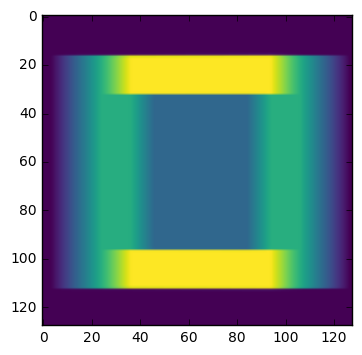

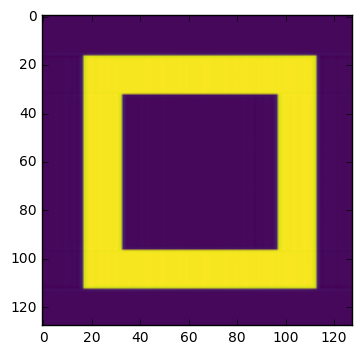

In [18]:
#-----------------------------------------------------------------------
#Copyright 2013 Centrum Wiskunde & Informatica, Amsterdam
#
#Author: Daniel M. Pelt
#Contact: D.M.Pelt@cwi.nl
#Website: http://dmpelt.github.io/pyastratoolbox/
#
#
#This file is part of the Python interface to the
#All Scale Tomographic Reconstruction Antwerp Toolbox ("ASTRA Toolbox").
#
#The Python interface to the ASTRA Toolbox is free software: you can redistribute it and/or modify
#it under the terms of the GNU General Public License as published by
#the Free Software Foundation, either version 3 of the License, or
#(at your option) any later version.
#
#The Python interface to the ASTRA Toolbox is distributed in the hope that it will be useful,
#but WITHOUT ANY WARRANTY; without even the implied warranty of
#MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#GNU General Public License for more details.
#
#You should have received a copy of the GNU General Public License
#along with the Python interface to the ASTRA Toolbox. If not, see <http://www.gnu.org/licenses/>.
#
#-----------------------------------------------------------------------

import astra
import numpy as np

vol_geom = astra.create_vol_geom(128, 128, 128)

angles = np.linspace(0, np.pi, 180,False)
# proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, 128, 192, angles)

pixel_size = 2.82473e-3
os_distance = 56.135 / pixel_size # object-sample distance
ds_distance = 225.082 / pixel_size # detector-sample distance
detector_size = 128
    
#     proj_geom = astra.create_proj_geom('cone', 1.0, 1.0, 32, 64, angles, 1000, 0)
proj_geom = astra.create_proj_geom('cone', ds_distance / os_distance,ds_distance / os_distance,
                                   detector_size, detector_size, angles,
                                   os_distance, (ds_distance - os_distance))

# Create a simple hollow cube phantom
cube = np.zeros((128,128,128))
cube[17:113,17:113,17:113] = 1
cube[33:97,33:97,33:97] = 0

# Create projection data from this
proj_id, proj_data = astra.create_sino3d_gpu(cube, proj_geom, vol_geom)

# Display a single projection image
import pylab
pylab.viridis()
pylab.figure(1)
pylab.imshow(proj_data[:,20,:])

# Create a data object for the reconstruction
rec_id = astra.data3d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the GPU
cfg = astra.astra_dict('FDK_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 150 iterations of the algorithm
# Note that this requires about 750MB of GPU memory, and has a runtime
# in the order of 10 seconds.
astra.algorithm.run(alg_id, 1)

# Get the result
rec = astra.data3d.get(rec_id)
pylab.figure(2)
pylab.imshow(rec[:,:,64])
pylab.show()


# Clean up. Note that GPU memory is tied up in the algorithm object,
# and main RAM in the data objects.
astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)


In [21]:
fp = np.memmap('1.tmp', dtype='float32', mode='w+', shape=(int(1e5),int(1e5)))


In [24]:
rm 1.tmp